In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm, trange

In [2]:
# Label sizes
TICK_LABEL_SIZE = 18
AXIS_LABEL_SIZE = 24
TITLE_LABEL_SIZE = 32

In [3]:
baseline_dict = {
    'Baseline, eyes open': {'annotation': 'T0', 'runs': ['01']},
    'Baseline, eyes closed': {'annotation': 'T0', 'runs': ['02']},
}

task_dict = {
    'Resting state': {'annotation': 'T0', 'runs': ['03', '04', '05', '06','07', '08', '09', '10', '11', '12', '13', '14']},
    'Left fist, performed': {'annotation': 'T1', 'runs': ['03', '07' '11']},
    'Left fist, imagined': {'annotation': 'T1', 'runs': ['04', '08', '12']},
    'Both fists, performed': {'annotation': 'T1', 'runs': ['05', '09', '13']},
    'Both fists, imagined': {'annotation': 'T1', 'runs': ['06', '10', '14']},
    'Right fist, performed': {'annotation': 'T2', 'runs': ['03', '07', '11']},
    'Right fist, imagined': {'annotation': 'T2', 'runs': ['04', '08', '12']},
    'Both feet, performed': {'annotation': 'T2', 'runs': ['05', '09', '13']},
    'Both feet, imagined': {'annotation': 'T2', 'runs': ['06', '10', '14']}
}

In [4]:
import os

high_pass = 8.0
low_pass = 12.0


o = []
c = []

FOLDER = '../data/eegmmidb (raw)/files/'

for patient in tqdm(os.listdir(FOLDER)):
    for edf in os.listdir(FOLDER + patient):
        FILE = FOLDER + patient + '/' + edf
        if edf.endswith('R01.edf'):
            raw_open = get_raw(FILE, filter=True, high_pass=high_pass, low_pass=low_pass)
            mean_activity = (raw_open.get_data()**2).mean()
            o.append(mean_activity)
        elif edf.endswith('R02.edf'):
            raw_open = get_raw(FILE, filter=True, high_pass=high_pass, low_pass=low_pass)
            mean_activity = (raw_open.get_data()**2).mean()
            c.append(mean_activity)

100%|██████████| 109/109 [00:42<00:00,  2.54it/s]


In [5]:
def load_mmidb_data_dict(DATA_PATH, PARCELLATION, SNR):

    def sort_dict(dict):
        return {k: dict[k] for k in sorted(dict.keys())}

    PARCELLATION_PATH = DATA_PATH + 'mmidb_' + PARCELLATION + '/mmidb_'+ PARCELLATION

    delta_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_1.0_4.0_parallel.npy', allow_pickle=True).item()
    theta_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_4.0_8.0_parallel.npy', allow_pickle=True).item()
    alpha_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_8.0_12.0_parallel.npy', allow_pickle=True).item()
    beta_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_12.0_30.0_parallel.npy', allow_pickle=True).item()
    gamma_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_30.0_70.0_parallel.npy', allow_pickle=True).item()

    data_dict = {
        'Delta': sort_dict(delta_activity),
        'Theta': sort_dict(theta_activity),
        'Alpha': sort_dict(alpha_activity),
        'Beta': sort_dict(beta_activity),
        'Gamma': sort_dict(gamma_activity)
    }

    return data_dict

In [6]:
SNR = 100.0
#PARCELLATION = 'aparc.a2009s'
PARCELLATION = 'HCPMMP1_combined'
DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'

data_dict = load_mmidb_data_dict(DATA_PATH, PARCELLATION, SNR)

In [13]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

labels = get_labels(subjects_dir, parcellation_name = PARCELLATION)
labels = np.array(labels).flatten()

label_names = [label.name for label in labels]
#label_names

occipital_labels = [label for label in labels if 'Oc' in label.name]
occipital_labels

[<Label | fsaverage, 'Temporo-Parieto-Occipital Junction-lh', lh : 3406 vertices>,
 <Label | fsaverage, 'Temporo-Parieto-Occipital Junction-rh', rh : 4769 vertices>]

In [14]:
# get patient mean for specific task for alpha activity
def get_patient_task_mean(task, task_dict, patient, data, labels, suffix_left='-lh', suffix_right='-rh'):
    
    if labels !='all':
        idx = []
        for label in labels:
            idx.append(label_names.index(label.name))
    else:
        idx = np.arange(len(label_names))
            
    annotation = task_dict[task]['annotation']
    runs = task_dict[task]['runs']
    task_data = np.array([run[annotation][:,idx].mean() if run_name[-2:] in runs else 0 for run_name, run in data[patient].items()]).sum()

    return task_data

# get task data for all patient for open and closed eyes
def get_task_data(task, task_dict, data, labels):
    patient_activity = []

    for patient in data.keys():
        patient_activity.append(get_patient_task_mean(task, task_dict, patient, data, labels))
        
    return np.array(patient_activity)

def plot_baseline(baseline_activity, patient_names, title=None):

    # set width of bar
    barWidth = 0.4

    # make plot
    fig, ax = plt.subplots(1, 1, figsize=(32, 6), sharey=True)

    # Set position of bar on X axis
    X = np.arange(baseline_activity.shape[1])
    br1 = [x - barWidth/2 for x in X]
    br2 = [x + barWidth/2 for x in X]

    left_color = 'tomato'
    right_color = 'lightblue'

    # Make the plot
    ax.bar(br1, baseline_activity[0], color=left_color, width = barWidth,
            edgecolor ='grey', label ='OPEN')
    ax.bar(br2, baseline_activity[1], color=right_color, width = barWidth,
            edgecolor ='grey', label ='CLOSED')

    # Adding ticks
    ax.set_xlabel('Patients', fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel('Standardised Activity', fontsize=AXIS_LABEL_SIZE)
    ax.set_xticks(X, patient_names, fontsize=TICK_LABEL_SIZE, rotation=90)
    ax.margins(0)
    ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)

    ax.set_title(title, fontsize=TITLE_LABEL_SIZE)

    plt.tight_layout() 
    plt.legend(fontsize=TICK_LABEL_SIZE)
    plt.show()

def baseline_sanity_check_region_activity(data, baseline_dict, standardise=None, band='Alpha', labels='all'):

    baseline_open = get_task_data('Baseline, eyes open', baseline_dict, data[band], labels)
    baseline_closed = get_task_data('Baseline, eyes closed', baseline_dict, data[band], labels)

    baseline_total_mean = np.array([baseline_open, baseline_closed]).mean(0)

    if standardise == 'divide':
        baseline_open = baseline_open / baseline_total_mean
        baseline_closed = baseline_closed / baseline_total_mean

    elif standardise == 'subtract':
        baseline_open = baseline_open - baseline_total_mean
        baseline_closed = baseline_closed - baseline_total_mean

    elif standardise == 'both':
        baseline_open = (baseline_open - baseline_total_mean) / baseline_total_mean
        baseline_closed = (baseline_closed - baseline_total_mean) / baseline_total_mean
    else:
        baseline_open = baseline_open
        baseline_closed = baseline_closed

    baseline_activity = np.array([baseline_open, baseline_closed])

    patient_names = np.array(list(data[band].keys()))
    plot_baseline(baseline_activity, patient_names, title=f'Difference in Region Activity ({band}) between open and closed eyes, standardised by {standardise}')

def baseline_sanity_check_channel_activity(channel_activity_open, channel_activity_closed, patient_names, title=f'Difference in Channel Activity between open and closed eyes, standardised'):

    fig, ax = plt.subplots(1, 1, figsize=(32, 6))

    bar_width = 0.4

    open_color = 'tomato'
    closed_color = 'lightblue'

    baseline_total_mean = np.array([o, c]).mean(0)

    baseline_open = o / baseline_total_mean
    baseline_closed = c / baseline_total_mean

    x = np.arange(109)
    ax.bar(x-bar_width/2, baseline_open, color=open_color, width=bar_width)
    ax.bar(x+bar_width/2, baseline_closed, color=closed_color, width=bar_width)
    ax.margins(0)

    ax.set_xlabel('Patients', fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel('Standardised Activity', fontsize=AXIS_LABEL_SIZE)

    ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)
    ax.set_xticks(x, patient_names, fontsize=TICK_LABEL_SIZE, rotation=90)
    ax.legend(['OPEN', 'CLOSED'], fontsize=TICK_LABEL_SIZE)
    ax.set_title(title, fontsize=TITLE_LABEL_SIZE)
    plt.show()

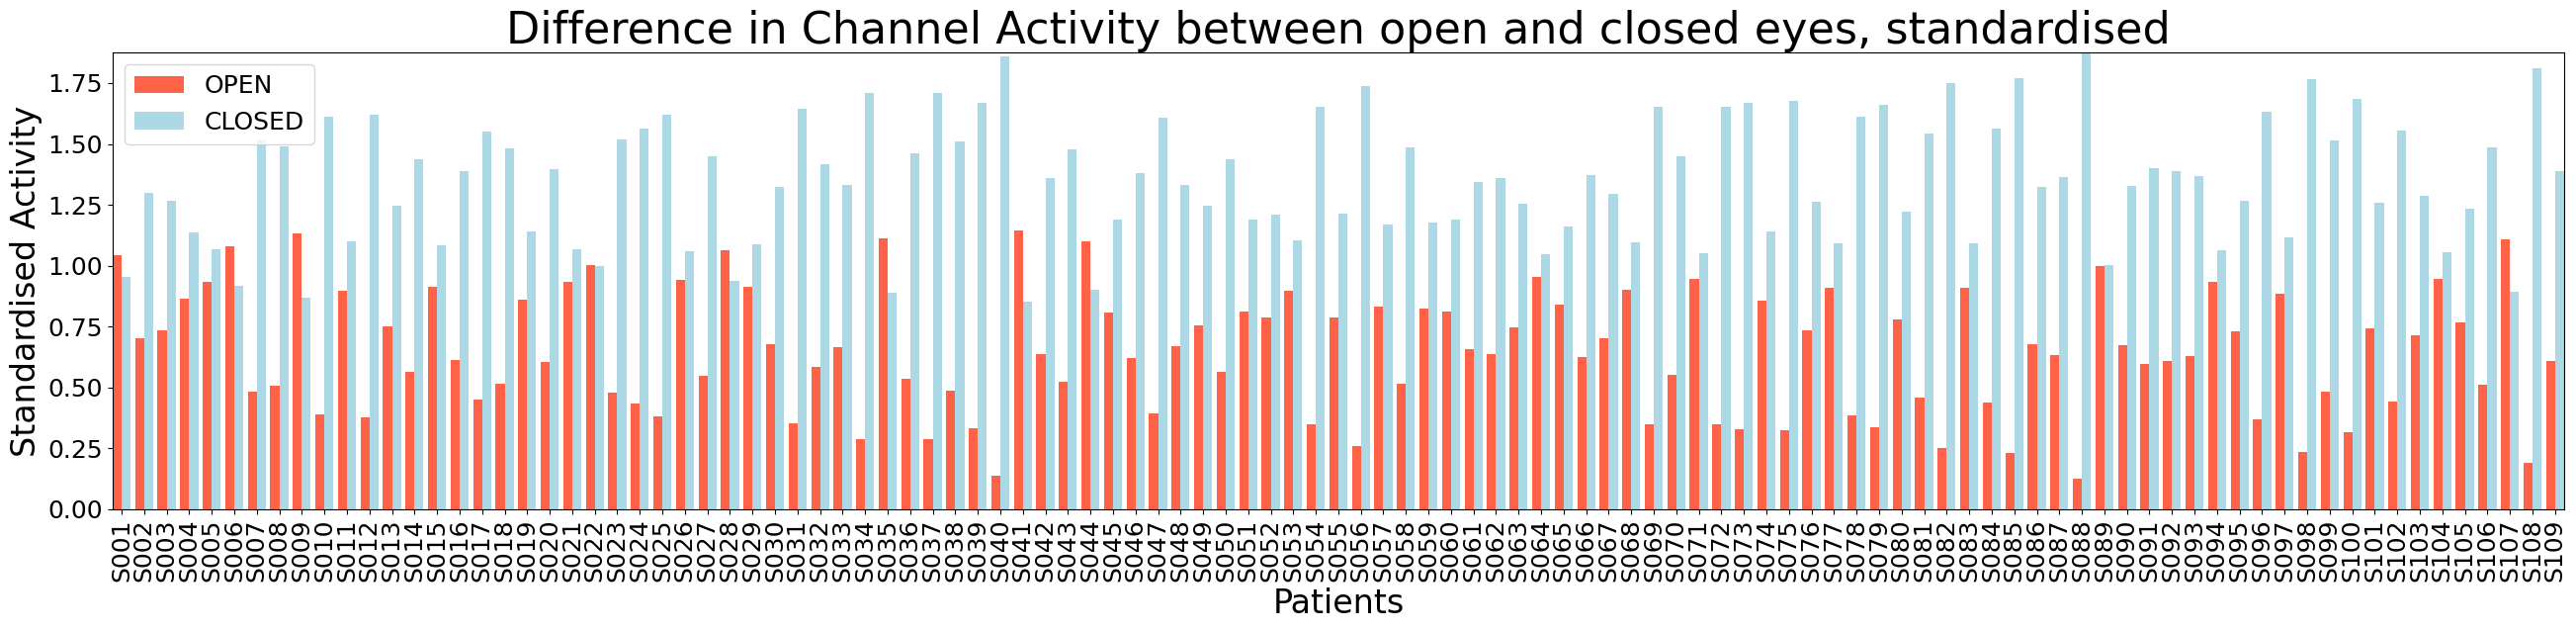

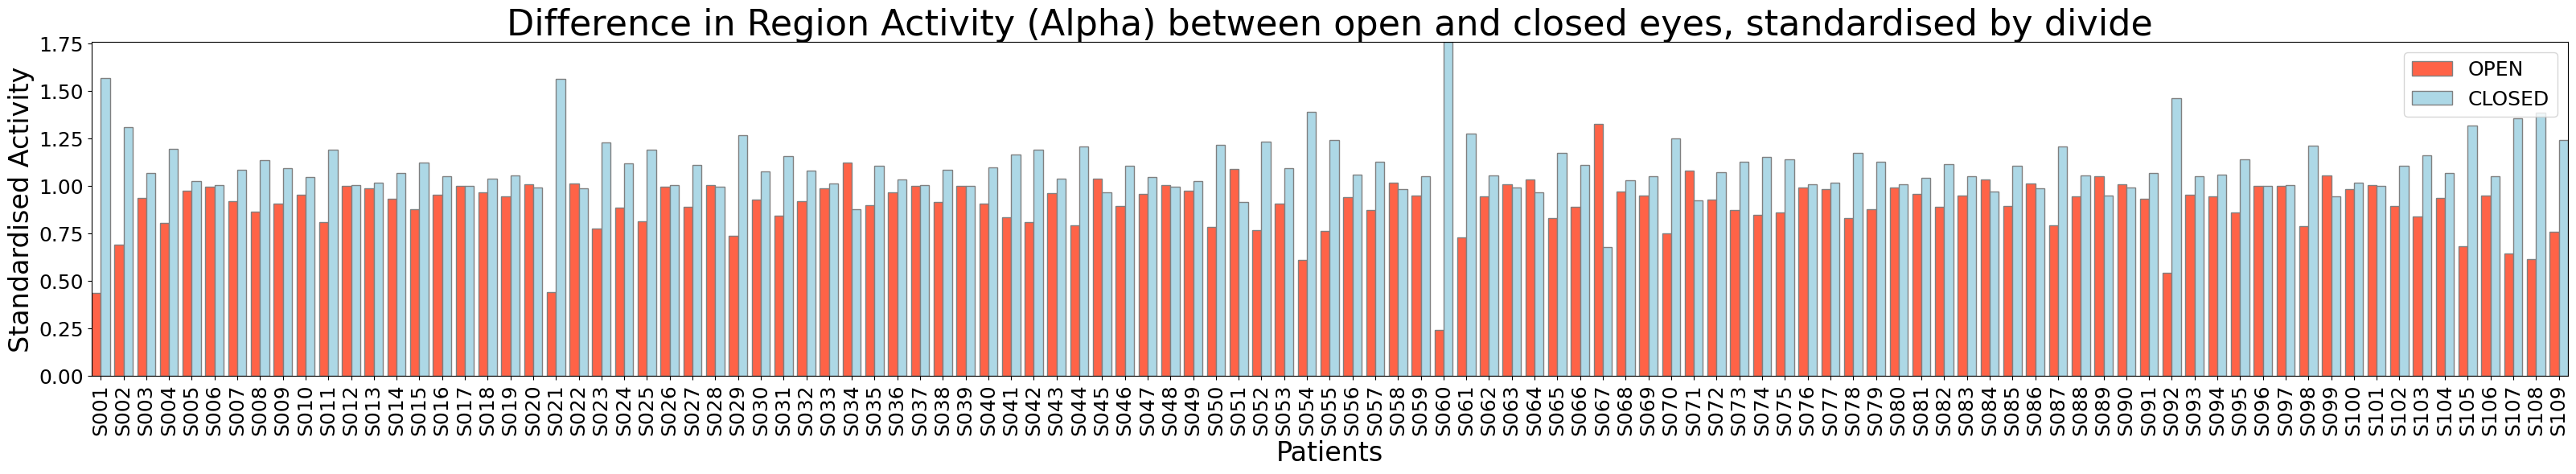

In [15]:
patient_names = np.array(list(data_dict['Alpha'].keys()))

baseline_sanity_check_channel_activity(o, c, patient_names)

#baseline_sanity_check_region_activity(data, baseline_dict, band='Alpha')
baseline_sanity_check_region_activity(data_dict, baseline_dict, standardise='divide', band='Alpha', labels=occipital_labels)
#baseline_sanity_check_region_activity(data, baseline_dict, standardise='subtract', band='Alpha')
#baseline_sanity_check_region_activity(data, baseline_dict, standardise='both', band='Alpha')

In [32]:
def plot_hemisphere_comparison(left_activity_prop, right_activity_prop, left_activity_summed, right_activity_summed, annotation_names, run_id):
    
    # Label sizes
    TICK_LABEL_SIZE = 18
    AXIS_LABEL_SIZE = 24
    TITLE_LABEL_SIZE = 32

    # set width of bar
    barWidth = 0.4

    # make plot
    fig, ax = plt.subplots(1, 2, figsize=(32, 5), gridspec_kw={'width_ratios': [4, 1]}, sharey=True)

    # Set position of bar on X axis
    X = np.arange(len(left_activity_prop))
    br1 = [x - barWidth/2 for x in X]
    br2 = [x + barWidth/2 for x in X]

    left_color = 'lightsteelblue'
    right_color = 'springgreen'

    
    # Make the plot
    ax[0].bar(br1, left_activity_prop, color=left_color, width = barWidth,
            edgecolor ='grey', label ='LEFT')
    ax[0].bar(br2, right_activity_prop, color=right_color, width = barWidth,
            edgecolor ='grey', label ='RIGHT')
    
    ax[0].axvline(x=annotation_names.count('T0')-.5, color='black', linestyle='--', linewidth=1)
    ax[0].axvline(x=annotation_names.count('T0')+annotation_names.count('T1')-.5, color='black', linestyle='--', linewidth=1)


    # Adding ticks
    ax[0].set_xlabel('Annotations', fontsize=AXIS_LABEL_SIZE)
    ax[0].set_ylabel('Proportional Activity', fontsize=AXIS_LABEL_SIZE)
    ax[0].set_xticks(X, annotation_names, fontsize=TICK_LABEL_SIZE)
    ax[0].margins(.01)
    ax[0].tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)

    X2 = np.arange(len(left_activity_summed))
    br3 = [x - barWidth/2 for x in X2]
    br4 = [x + barWidth/2 for x in X2]

    # Make the plot
    ax[1].bar(br3, left_activity_summed, color =left_color, width = barWidth,
            edgecolor ='grey', label ='LEFT')
    ax[1].bar(br4, right_activity_summed, color =right_color, width = barWidth,
            edgecolor ='grey', label ='RIGHT')

    ax[1].set_xlabel('Annotations Summed', fontsize=AXIS_LABEL_SIZE)
    ax[1].set_xticks(X2, ['T0', 'T1', 'T2'], fontsize=TICK_LABEL_SIZE)

    T1_action = 'Left Fist' if run_id[-2:] in ['03', '04', '07', '08', '11', '12'] else 'Both Fists'
    T2_action = 'Right Fist' if run_id[-2:] in ['03', '04', '07', '08', '11', '12'] else 'Both Feet'

    fig.suptitle(f'Run {run_id} (Left vs Right Activity), T0: Rest, T1: {T1_action}, T2: {T2_action}', fontsize=TITLE_LABEL_SIZE)

    plt.tight_layout() 
    plt.legend(fontsize=TICK_LABEL_SIZE, loc='lower right')
    plt.show()

def compare_hemipheres(run, run_id, number_labels=150, standardize=True, show_plot=True):

    left_activity_prop = np.array([])
    right_activity_prop = np.array([])

    left_activity_summed = np.array([])
    right_activity_summed = np.array([])

    annotation_names = []

    #baseline = np.array([run['T0'][i].sum() for i in range(run['T0'].shape[0])]).mean()
    
    baseline_left = np.array([run['T0'][i][:int(number_labels/2)].sum() for i in range(run['T0'].shape[0])]).mean()
    baseline_right = np.array([run['T0'][i][int(number_labels/2):].sum() for i in range(run['T0'].shape[0])]).mean()
    

    for annotation in run.keys(): # [T0,T1,T2]

        n_annotations = run[annotation].shape[0]

        annotation_names += [annotation for _ in range(n_annotations)]

        left_activity = np.array([run[annotation][i][:int(number_labels/2)].sum() for i in range(n_annotations)])
        right_activity = np.array([run[annotation][i][int(number_labels/2):].sum() for i in range(n_annotations)])
        
        if standardize:
            left_activity = left_activity / baseline_left
            right_activity = right_activity / baseline_right

        total_activity = left_activity + right_activity

        left_activity_prop = np.append(left_activity_prop, left_activity / total_activity)
        right_activity_prop = np.append(right_activity_prop, right_activity / total_activity)

        total_activity_summed = left_activity_prop.sum() + right_activity_prop.sum()

        left_activity_summed = np.append(left_activity_summed, left_activity_prop.sum() / total_activity_summed)
        right_activity_summed = np.append(right_activity_summed, right_activity_prop.sum() / total_activity_summed)

    if show_plot:
        plot_hemisphere_comparison(left_activity_prop, right_activity_prop, left_activity_summed, right_activity_summed, annotation_names, run_id)

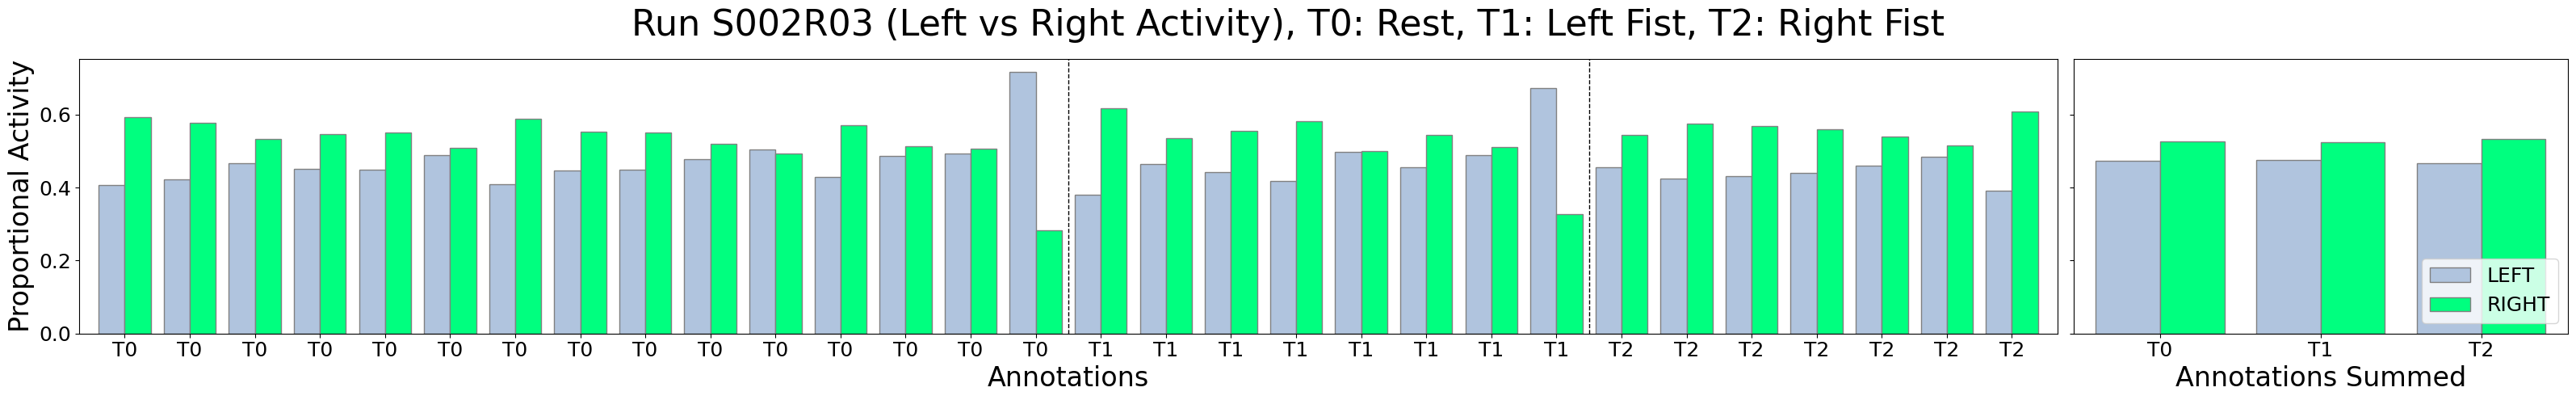

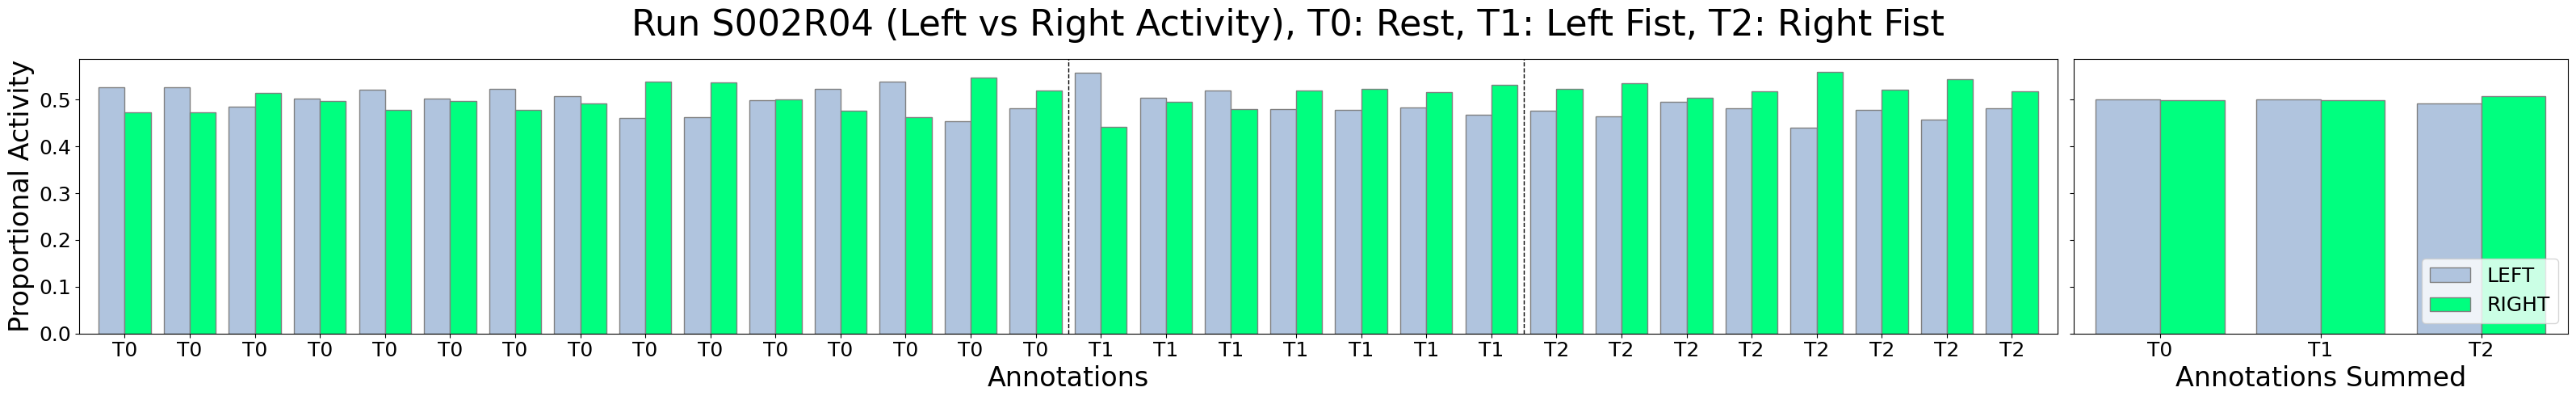

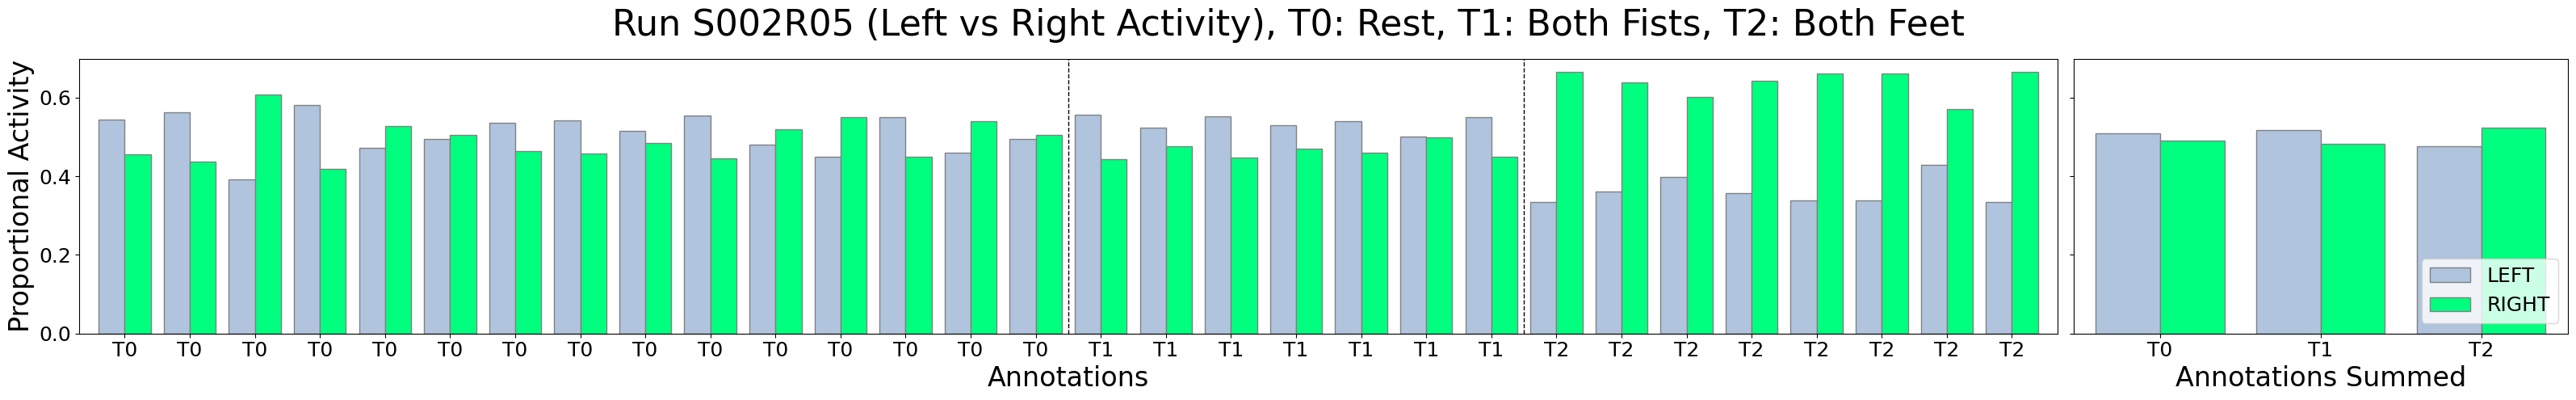

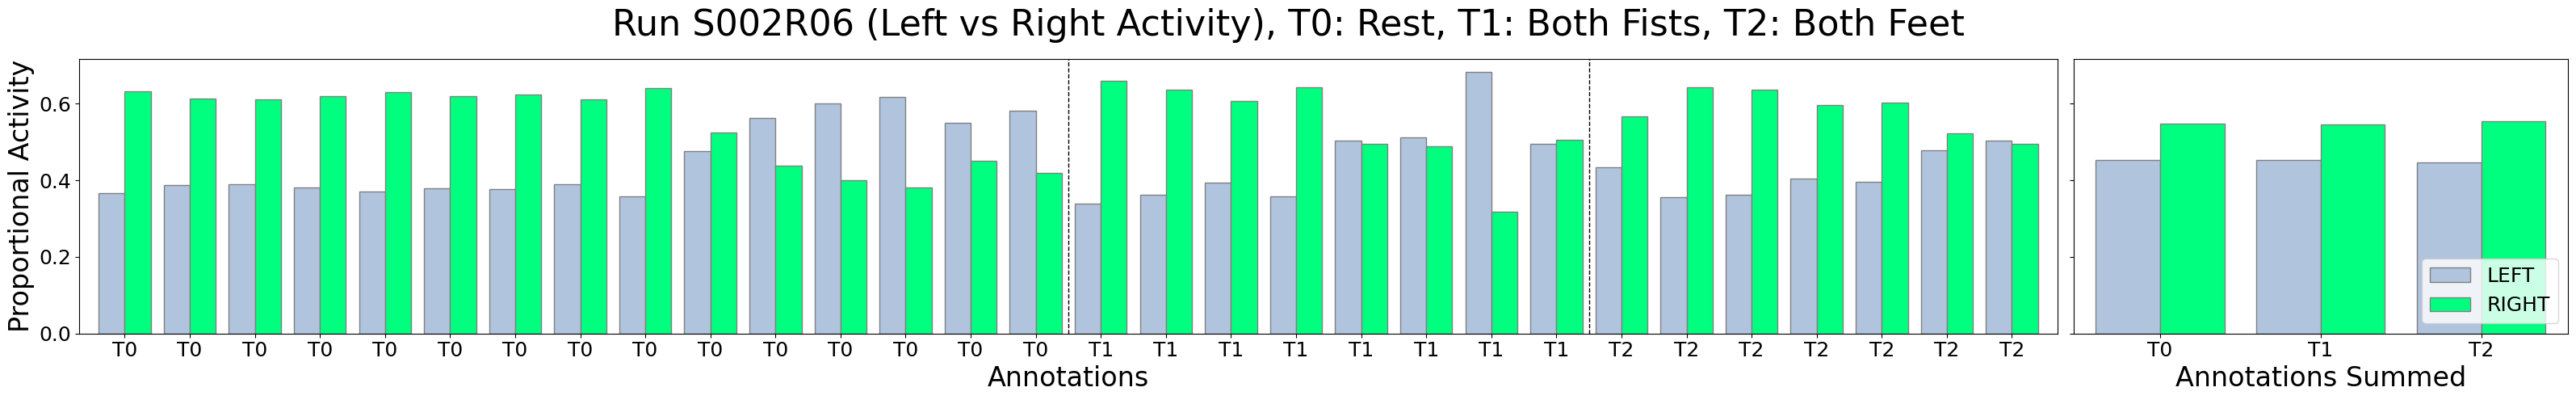

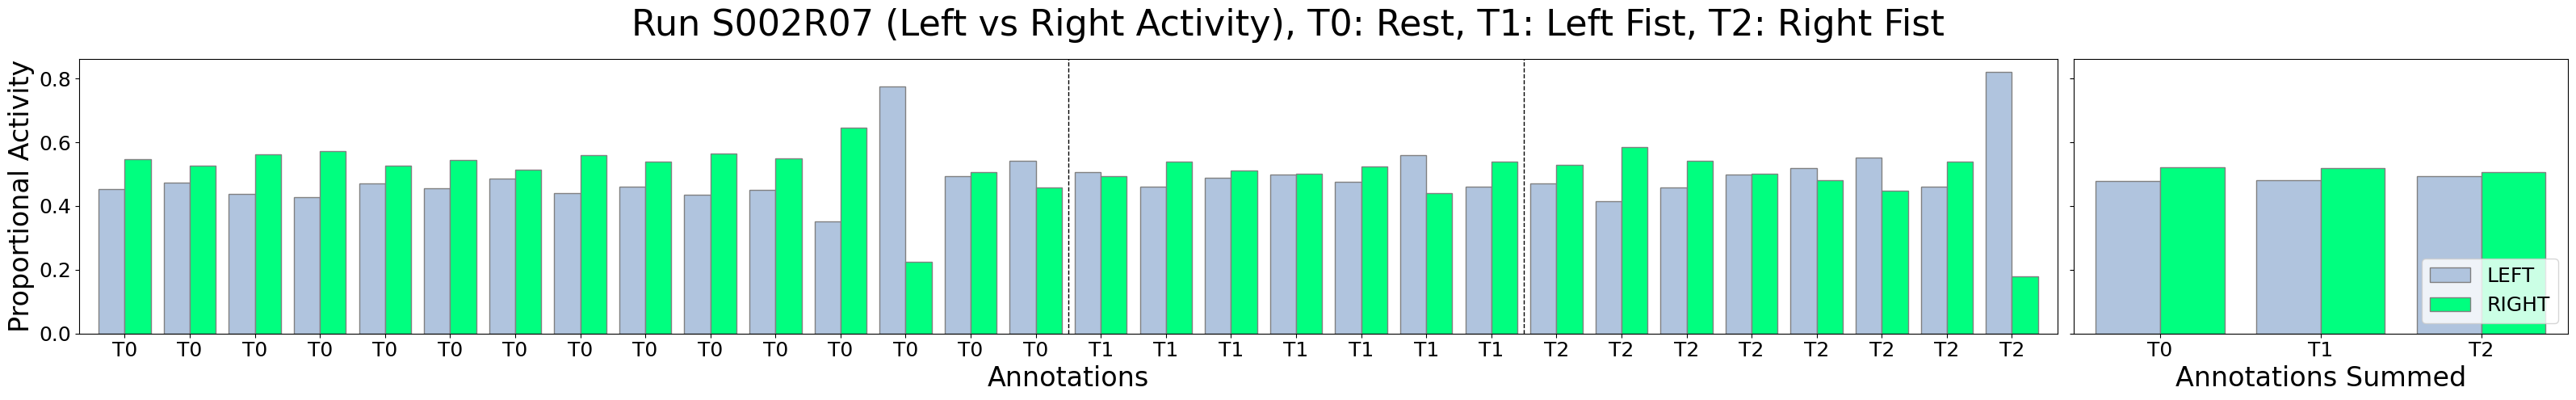

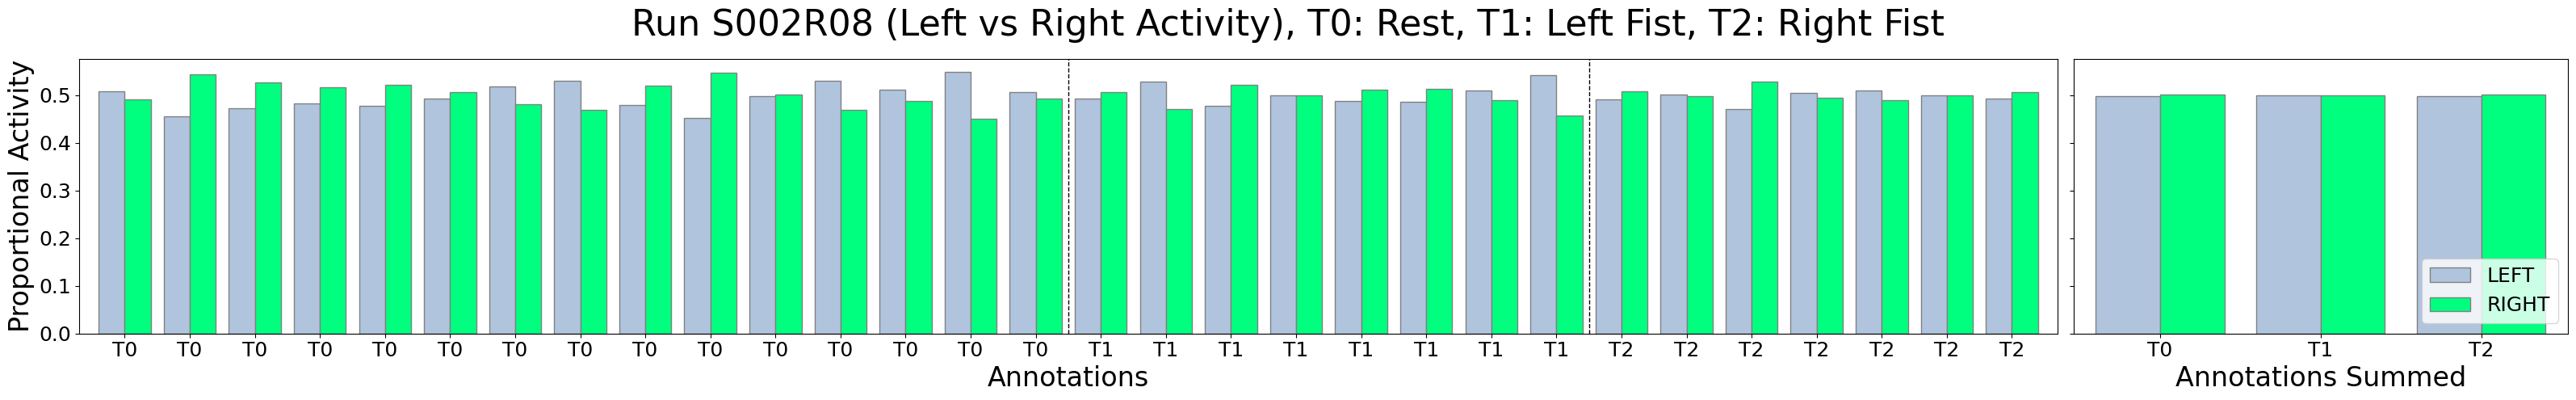

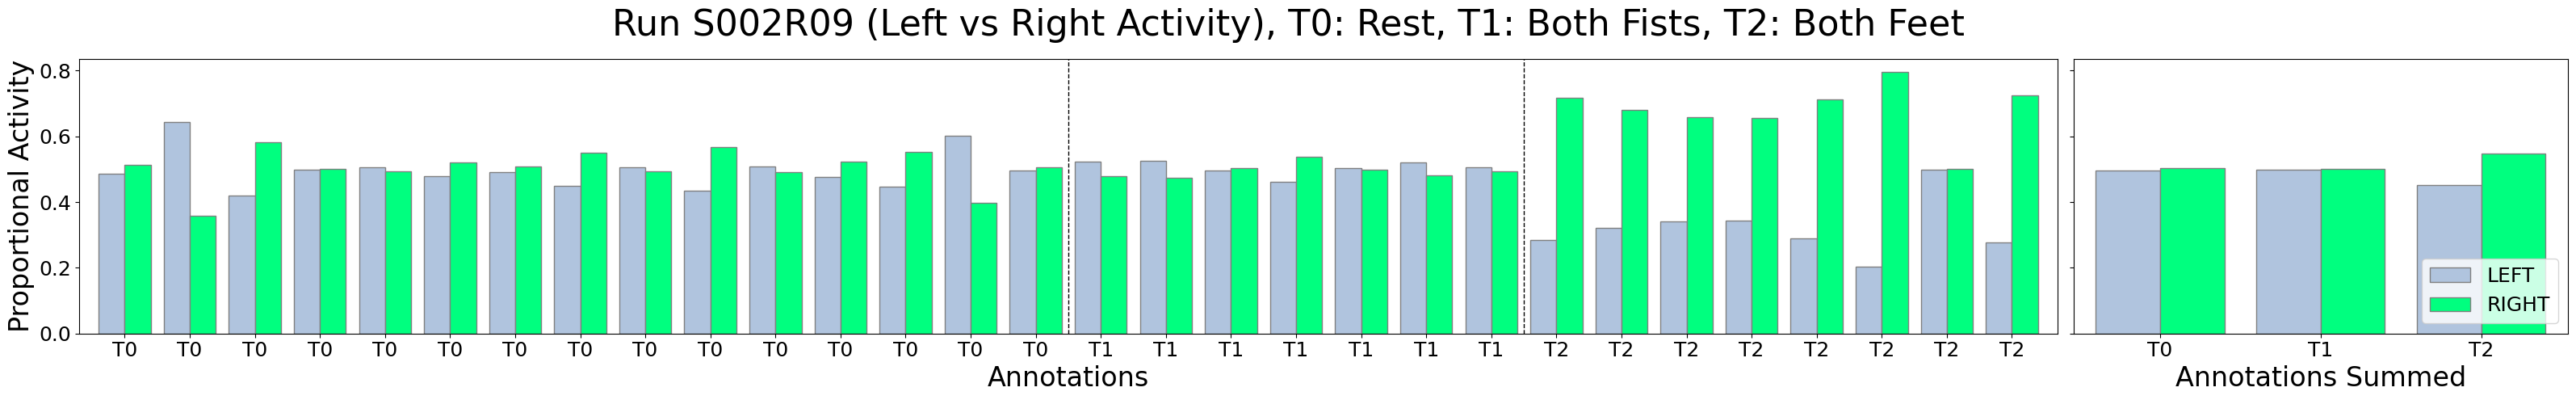

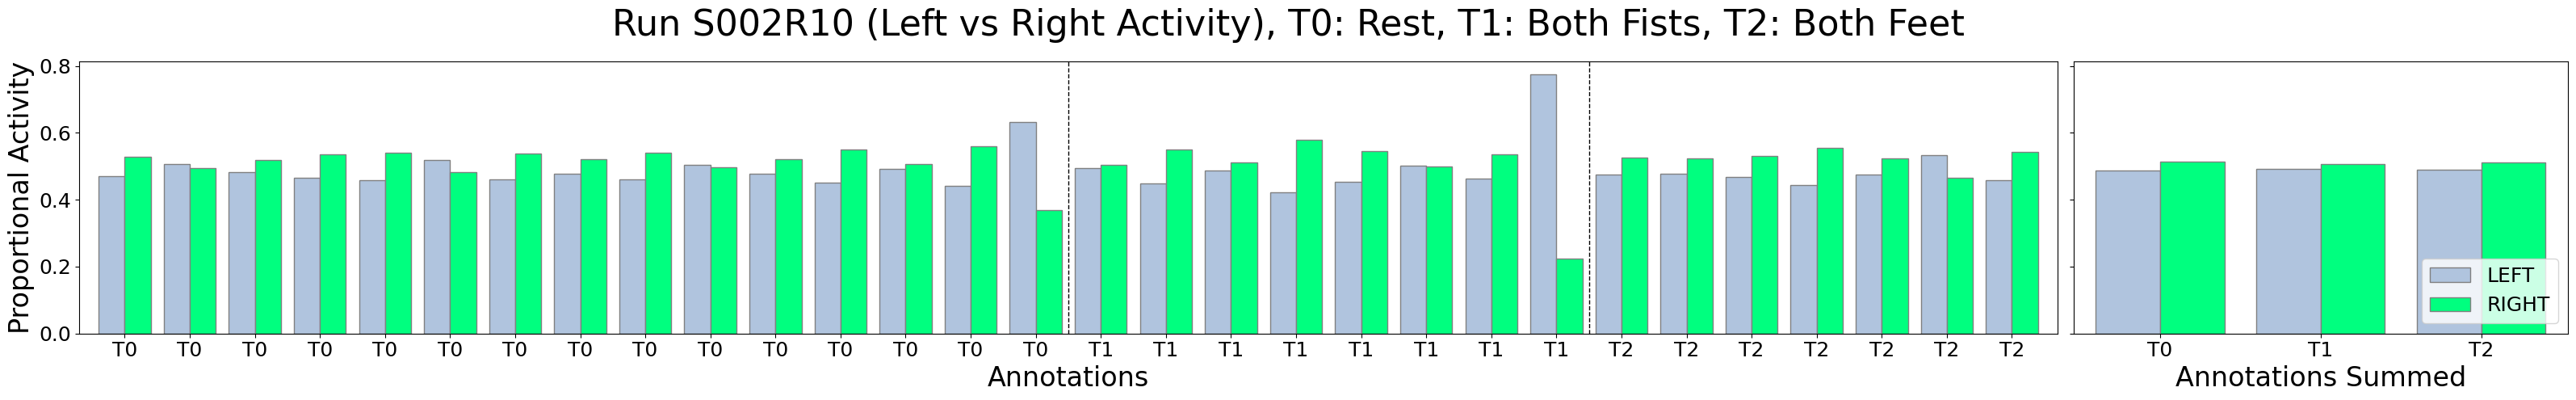

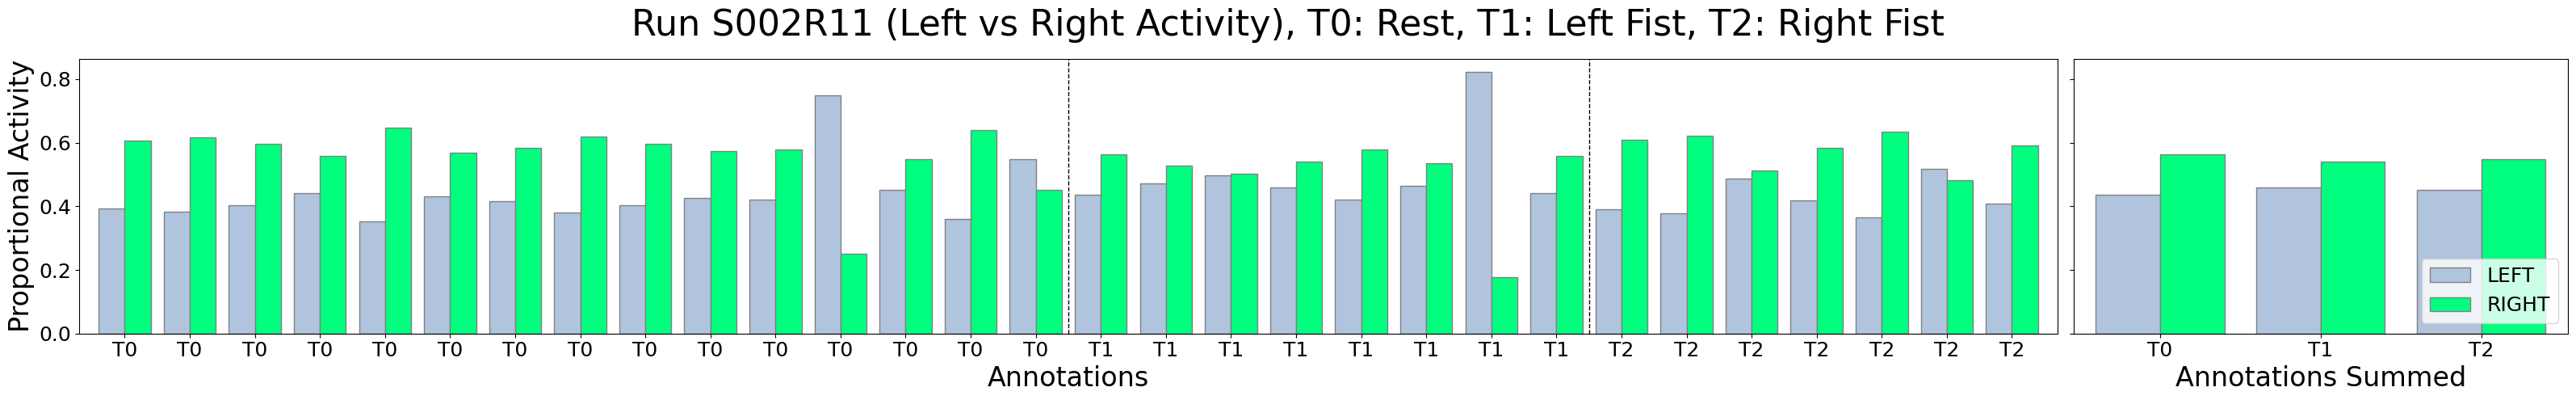

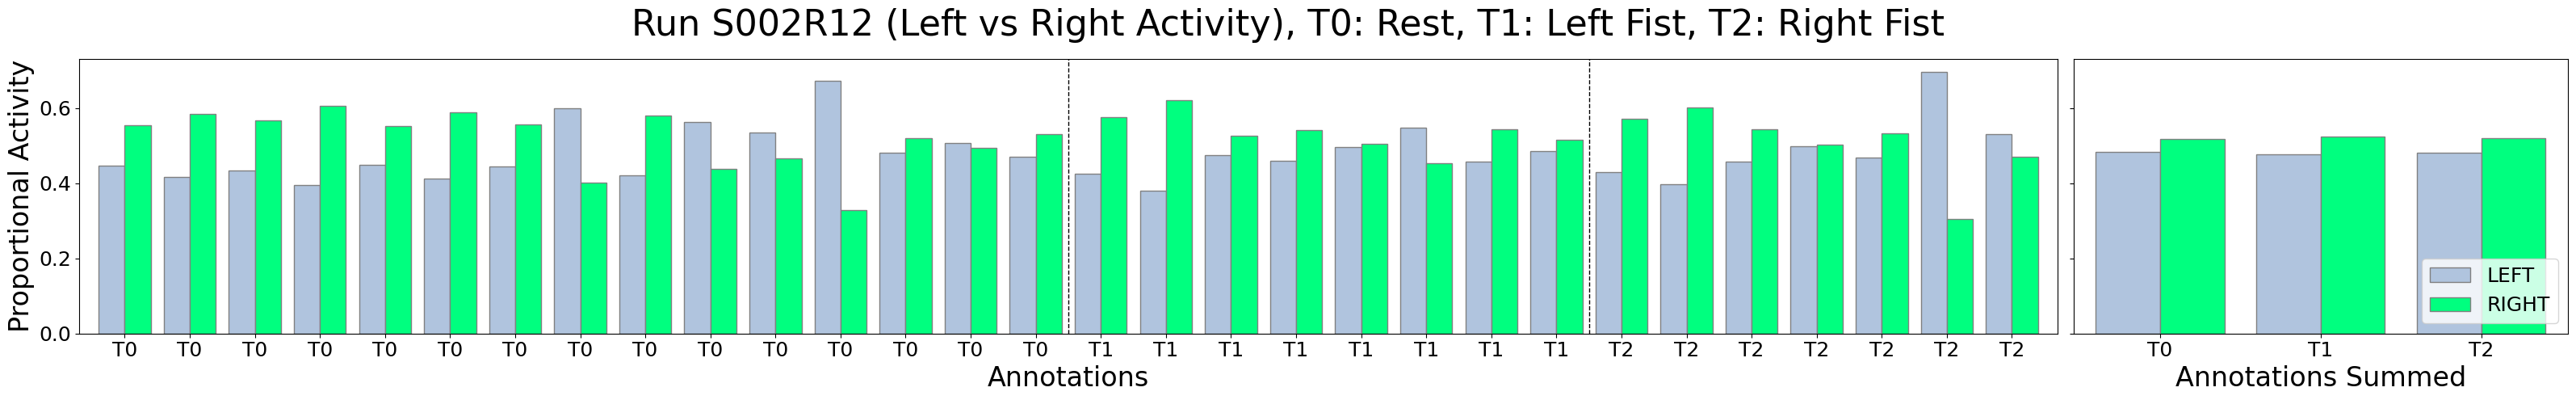

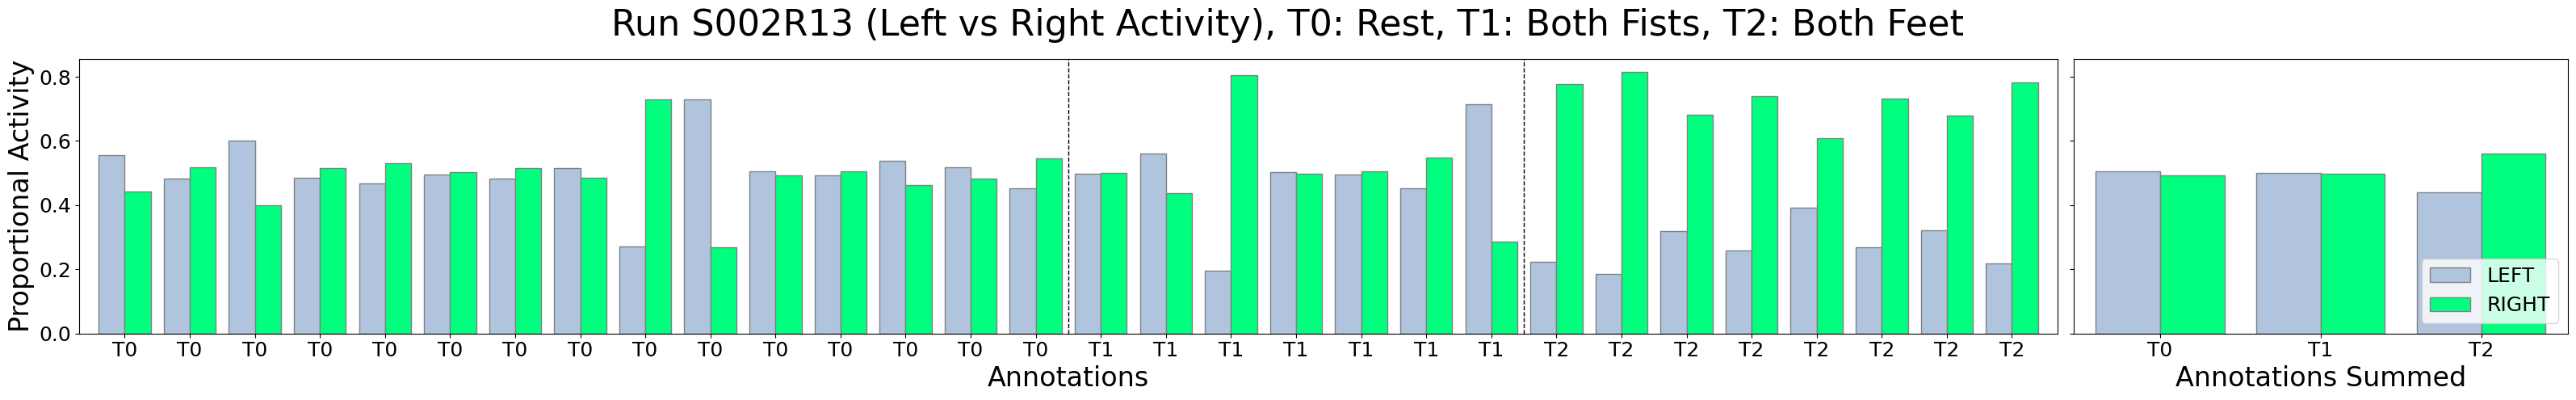

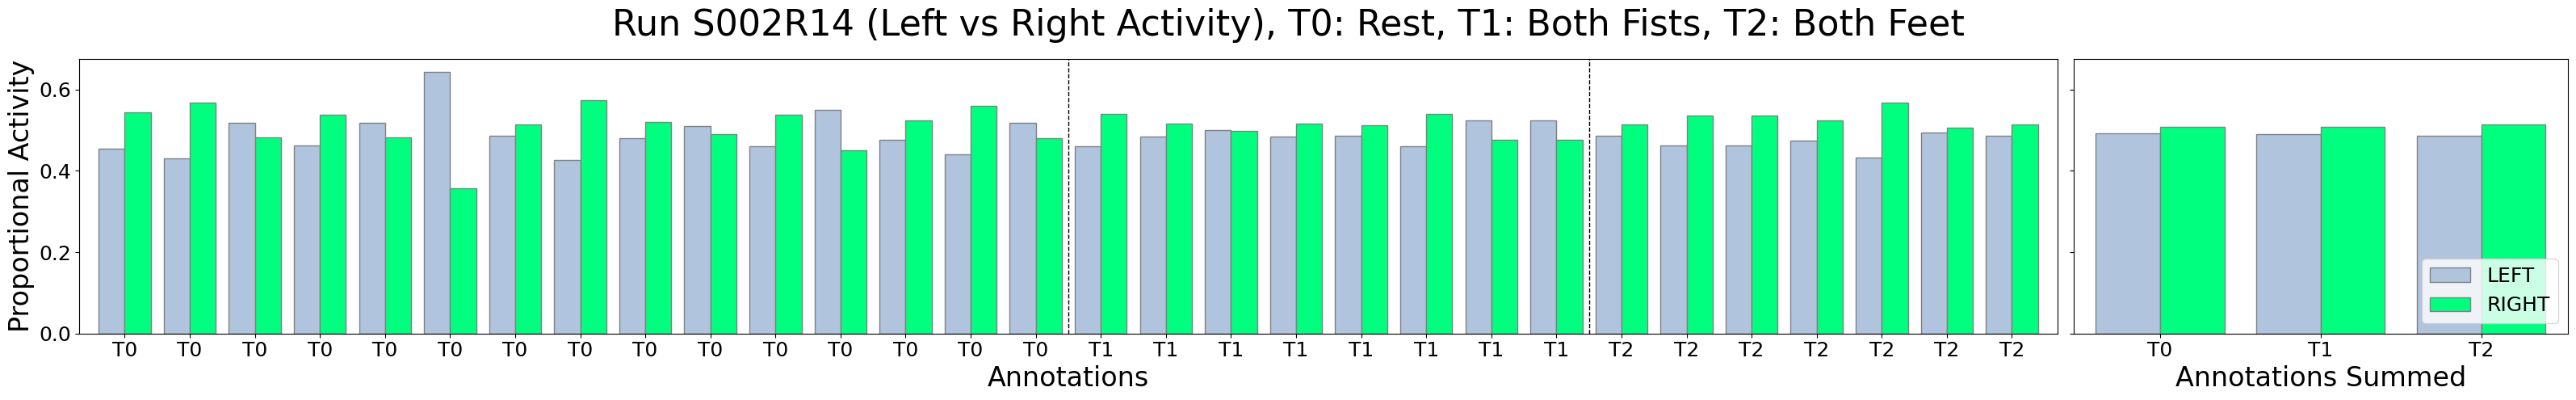

In [34]:
patient = 'S002'

for run_id in sorted(alpha_activity[patient])[2:]:
    run = alpha_activity[patient][run_id].copy()
    compare_hemipheres(run, run_id, number_labels=len(label_names), standardize=True, show_plot=True)

In [37]:
def compare_hemiphere_regions(data, task_dict, label_names, labels_of_interest, suffix_left='-lh', suffix_right='-rh'):

    label_comparison = {}

    for label in labels_of_interest:
        label_idx_left = label_names.index(label+suffix_left)
        label_idx_right = label_names.index(label+suffix_right)

        annotation_activity = np.zeros((9, 2))

        for j, task in enumerate(task_dict.keys()):
            annotation = task_dict[task]['annotation']
            runs = task_dict[task]['runs']

            left_activity = np.array([run[annotation][:,label_idx_left].mean() if run_id[-2:] in runs else 0 for patient in data.values() for run_id, run in patient.items()]).mean()
            right_activity = np.array([run[annotation][:,label_idx_right].mean() if run_id[-2:] in runs else 0 for patient in data.values() for run_id, run in patient.items()]).mean()
            annotation_activity[j, 0] = left_activity / (left_activity + right_activity)
            annotation_activity[j, 1] = right_activity / (left_activity + right_activity)

        label_comparison[label] = annotation_activity.T
            
    return label_comparison

def plot_region_comparison(comparison_dict, task_dict, band_name):

    # Label sizes
    TICK_LABEL_SIZE = 18
    AXIS_LABEL_SIZE = 24
    TITLE_LABEL_SIZE = 32

    # set width of bar
    barWidth = 0.4

    # make plot
    n_labels = len(comparison_dict.keys())
    fig, ax = plt.subplots(1, n_labels, figsize=(12*n_labels, 6), sharey=True)

    ax[0].set_ylabel('Proportional Activity', fontsize=AXIS_LABEL_SIZE)

    for idx, (label_name, proportions) in enumerate(comparison_dict.items()):

        # Set position of bar on X axis
        X = np.arange(proportions.shape[1])
        br1 = [x - barWidth/2 for x in X]
        br2 = [x + barWidth/2 for x in X]

        left_color = 'lightsteelblue'
        right_color = 'springgreen'

        # Make the plot
        ax[idx].bar(br1, proportions[0], color=left_color, width = barWidth,
                edgecolor ='grey', label ='LEFT')
        ax[idx].bar(br2, proportions[1], color=right_color, width = barWidth,
                edgecolor ='grey', label ='RIGHT')

        # Adding ticks
        ax[idx].set_xlabel('Annotations', fontsize=AXIS_LABEL_SIZE)
        ax[idx].set_xticks(X, task_dict.keys(), fontsize=TICK_LABEL_SIZE, rotation=45)
        ax[idx].margins(.01)
        ax[idx].tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)

        ax[idx].set_title(label_name + ', ' + band_name, fontsize=TITLE_LABEL_SIZE)

    plt.tight_layout() 
    plt.legend(fontsize=TICK_LABEL_SIZE)
    plt.show()

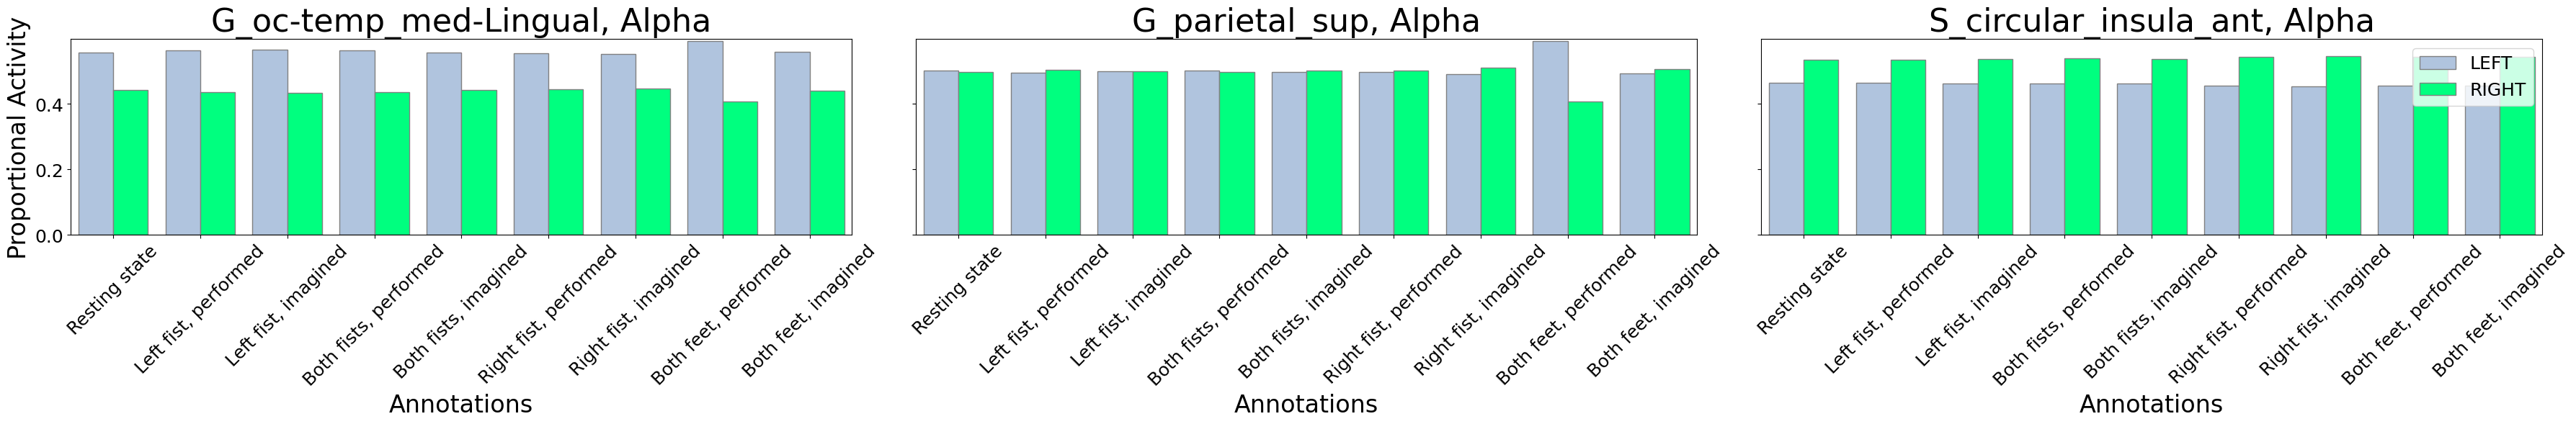

In [38]:
labels_of_interest = ['G_oc-temp_med-Lingual', 'G_parietal_sup', 'S_circular_insula_ant']
#labels_of_interest = ['Dorsal Stream Visual Cortex',  'Primary Visual Cortex (V1)']

for band_name, activity in [('Alpha', data['Alpha'])]:#data.items():
    comparison_dict = compare_hemiphere_regions(activity, task_dict, label_names, labels_of_interest)
    plot_region_comparison(comparison_dict, task_dict, band_name)

In [19]:
def plot_region_differences(activity_differences, neutral_labels, band_name, task_dict):

    # Label sizes
    TICK_LABEL_SIZE = 18
    AXIS_LABEL_SIZE = 24
    TITLE_LABEL_SIZE = 32

    # set width of bar
    barWidth = 0.1

    # make plot
    fig, ax = plt.subplots(1, 1, figsize=(32, 16))

    number_regions = activity_differences.shape[1]
    # Set position of bar on X axis
    X = np.arange(number_regions)
    br1 = [x - 4*barWidth for x in X]
    br2 = [x - 3*barWidth for x in X]
    br3 = [x - 2*barWidth for x in X]
    br4 = [x - barWidth for x in X]
    br5 = [x for x in X]
    br6 = [x + barWidth for x in X]
    br7 = [x + 2*barWidth for x in X]
    br8 = [x + 3*barWidth for x in X]
    br9 = [x + 4*barWidth for x in X]

    brs = [br1, br2, br3, br4, br5, br6, br7, br8, br9]
    #colors = ['salmon', 'lightblue', 'deepskyblue', 'lightgreen', 'lime']
    colors = ['#1f77b4',  '#ffbb78',  '#ffbb78','#ff7f0e','#ff7f0e', '#98df8a', '#98df8a','#2ca02c','#2ca02c']
    #labels = ['T0: Resting state', 'T1: Left fist', 'T1: Both Fists', 'T2: Rigth fist', 'T2: Both feet']
    labels = list(task_dict.keys())

    # Make the plot
    for idx in range(activity_differences.shape[0]):
        ax.bar(brs[idx], activity_differences[idx,:], color=colors[idx], width = barWidth,
                edgecolor ='grey', label=labels[idx])

    # Adding ticks
    ax.set_xlabel('Brain Regions', fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel('Difference in Activity', fontsize=AXIS_LABEL_SIZE)

    ax.set_xticks(X, neutral_labels, fontsize=TICK_LABEL_SIZE, rotation=90)
    ax.margins(.01)
    ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)

    fig.suptitle(f'Difference in Hemispheres (Left - Right) for {number_regions} Regions ({band_name})', fontsize=TITLE_LABEL_SIZE)

    plt.tight_layout() 
    plt.legend(fontsize=TICK_LABEL_SIZE)
    plt.show()

def examine_activity_differences(data, label_names, task_dict, band_name, suffix_left='-lh', suffix_right='-rh', standardize=True):

    activity_differences = np.zeros((9, int(len(label_names)/2))) # 11-2 = 9 tasks, 150/2 = 75

    neutral_labels = np.unique([name[:-3] for name in label_names])
    for idx, label_name in tqdm(enumerate(neutral_labels)):
        label_name = label_name
        label_idx_left = label_names.index(label_name+suffix_left)
        label_idx_right = label_names.index(label_name+suffix_right)

        baseline_task = 'Resting state'
        baseline_annotation = task_dict[baseline_task]['annotation']
        baseline_runs = task_dict[baseline_task]['runs']
        baseline_left = np.array([run[baseline_annotation][:,label_idx_left].mean() if run_id[-2:] in baseline_runs else 0 for patient in data.values() for run_id, run in patient.items()]).mean()
        baseline_right = np.array([run[baseline_annotation][:,label_idx_right].mean() if run_id[-2:] in baseline_runs else 0 for patient in data.values() for run_id, run in patient.items()]).mean()


        for j, task in enumerate(task_dict.keys()):
            annotation = task_dict[task]['annotation']
            runs = task_dict[task]['runs']

            left_activity = np.array([run[annotation][:,label_idx_left].mean() if run_id[-2:] in runs else 0 for patient in data.values() for run_id, run in patient.items()]).mean()
            right_activity = np.array([run[annotation][:,label_idx_right].mean() if run_id[-2:] in runs else 0 for patient in data.values() for run_id, run in patient.items()]).mean()

            if standardize:
                left_activity = left_activity / baseline_left
                right_activity = right_activity / baseline_right

            activity_differences[j, idx] = (left_activity - right_activity)

    plot_region_differences(activity_differences, neutral_labels, band_name, task_dict)

23it [00:01, 18.17it/s]


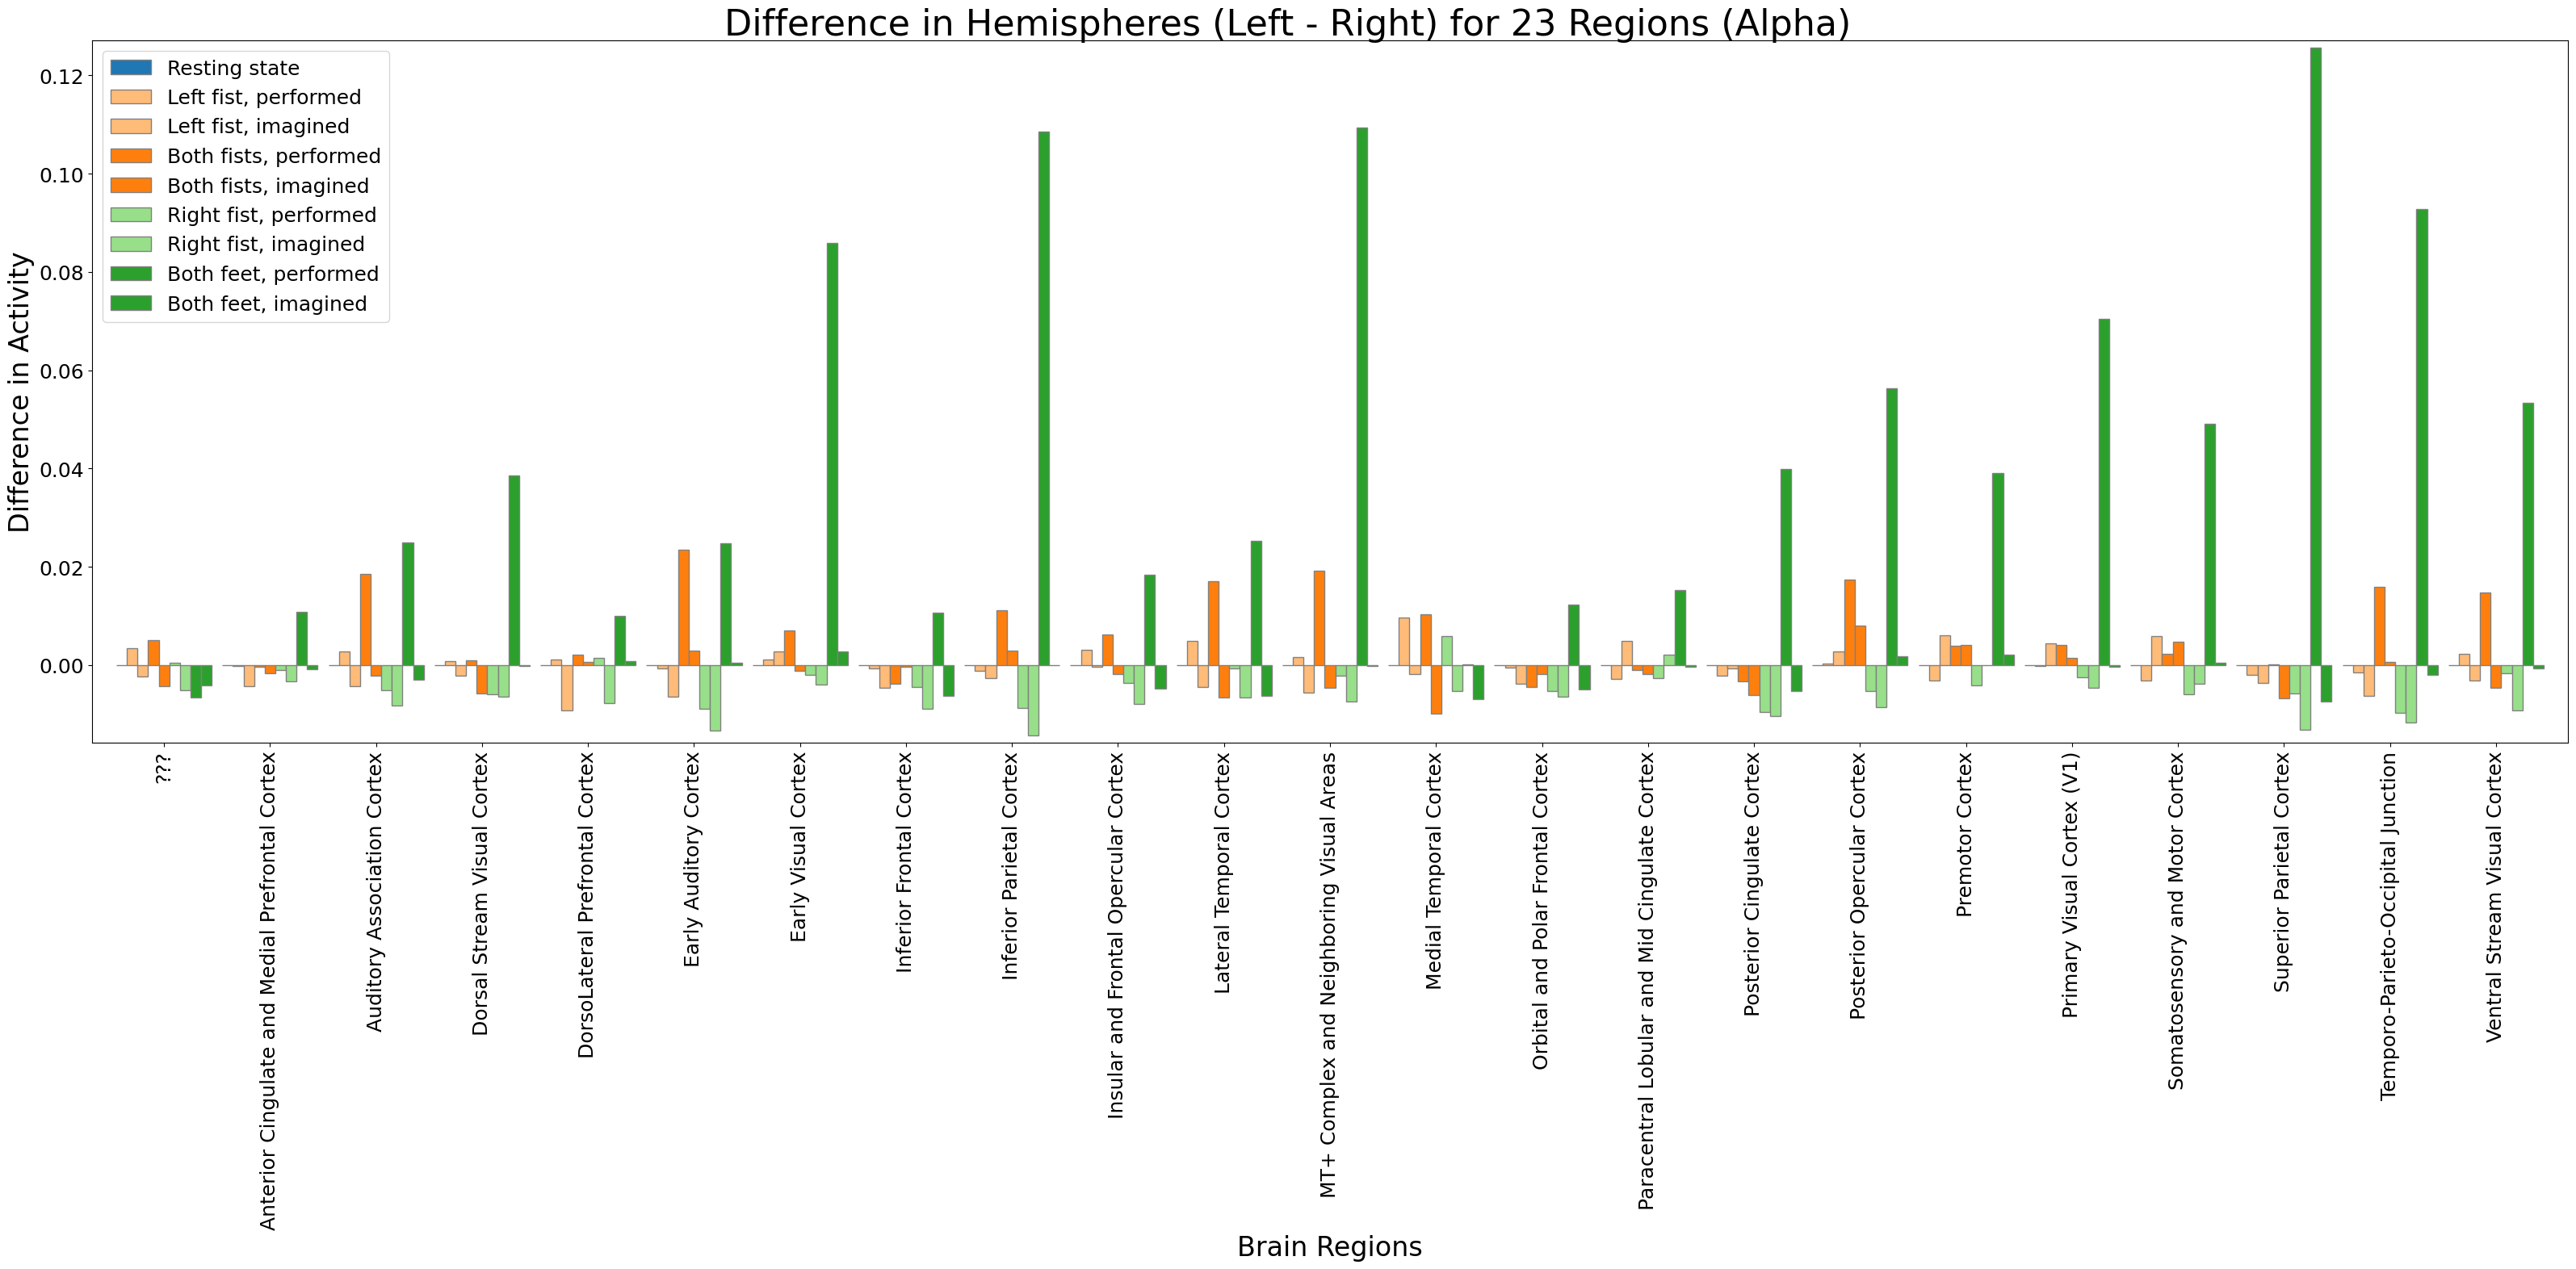

In [20]:
#for band_name, activity in data.items():
examine_activity_differences(data_dict['Alpha'], label_names, task_dict, 'Alpha')